数据基本信息:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2013-01-31 to 2023-07-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  126 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB

缺失值统计:
temperature    1
dtype: int64


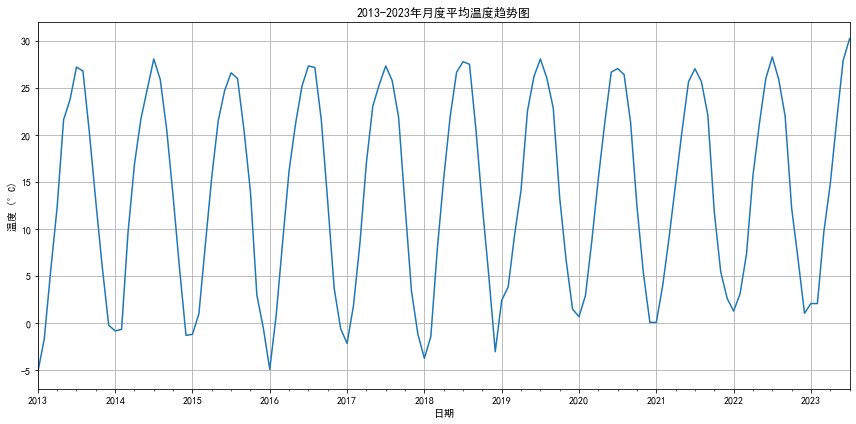

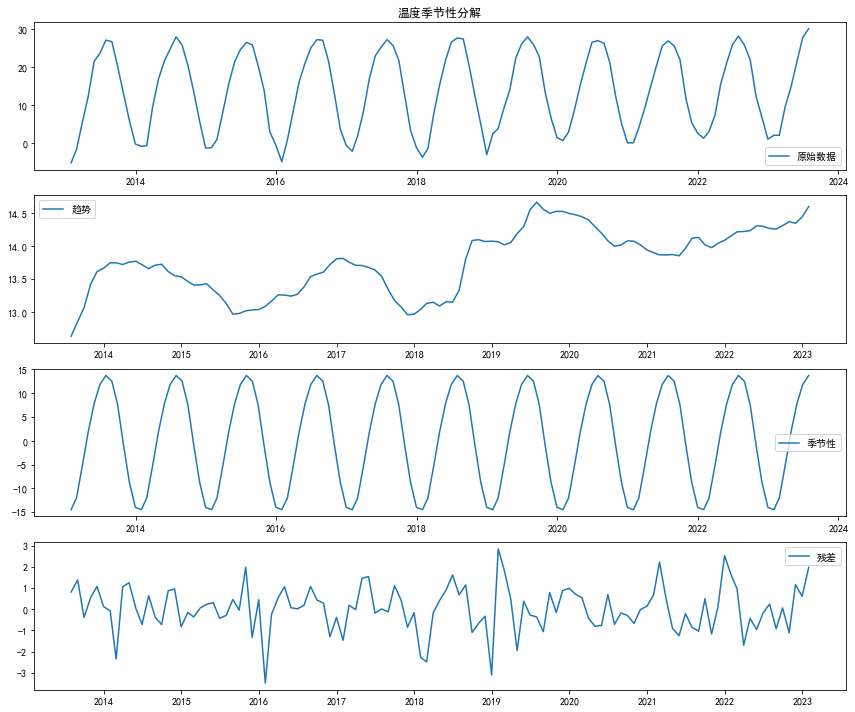


测试集RMSE: 1.22°C


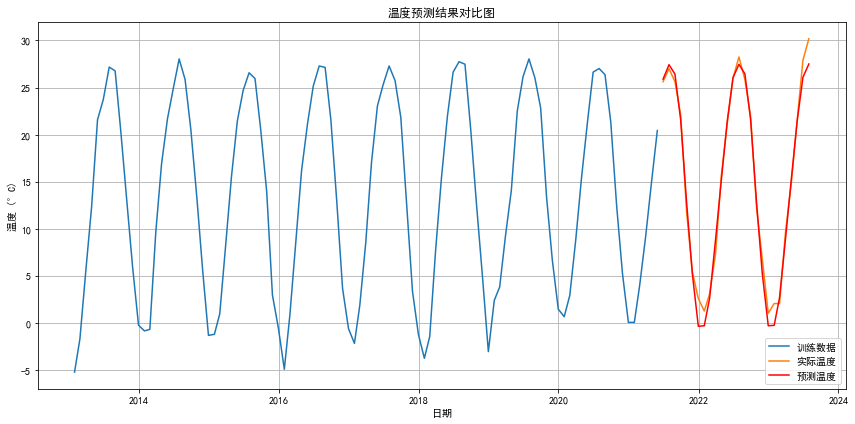

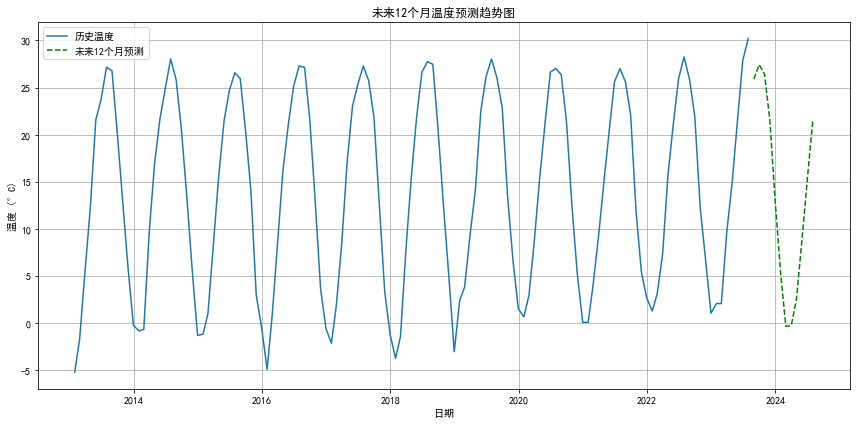


未来12个月温度预测已保存至 'C:\Users\PC\Desktop\温度预测结果\未来12个月温度预测.csv'
模型评估报告已保存至 'C:\Users\PC\Desktop\温度预测结果\模型评估报告.txt'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
import os
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建保存预测结果的目录（如果不存在）
output_dir = r"C:\Users\PC\Desktop\温度预测结果"
os.makedirs(output_dir, exist_ok=True)

# 读取温度数据
df = pd.read_csv(r"C:\Users\PC\Desktop\数据驱动清洗后数据\2013-2023monthly_avg_temperature.csv")

# 转换日期格式
df['date'] = pd.to_datetime(df['date'])

# 温度列——数值类型
df['temperature'] = pd.to_numeric(df['temperature'])

# 设置日期为索引
df.set_index('date', inplace=True)

# 数据探索
print("数据基本信息:")
df.info()

# 检查缺失值
print("\n缺失值统计:")
print(df.isnull().sum())

# 填充缺失值（如果有）
df['temperature'].fillna(method='ffill', inplace=True)

# 数据可视化 - 月度平均温度趋势
plt.figure(figsize=(12, 6))
df['temperature'].plot(title='2013-2023年月度平均温度趋势图')
plt.xlabel('日期')
plt.ylabel('温度 (°C)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '月度平均温度趋势.png'))
plt.show()

# 季节性分解
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['temperature'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# 数据可视化 - 季节性分解
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(df['temperature'], label='原始数据')
plt.title('温度季节性分解')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='趋势')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='季节性')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='残差')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '温度季节性分解.png'))
plt.show()

# 划分训练集和测试集
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# ARIMA模型训练与预测
# 这里使用简单参数，实际应用中建议通过AIC/BIC等选择最优参数
model = ARIMA(train['temperature'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# 预测测试集
predictions = model_fit.forecast(steps=len(test))
predictions.index = test.index

# 计算RMSE
rmse = np.sqrt(mean_squared_error(test['temperature'], predictions))
print(f'\n测试集RMSE: {rmse:.2f}°C')

# 数据可视化 - 预测结果
plt.figure(figsize=(12, 6))
plt.plot(train['temperature'], label='训练数据')
plt.plot(test['temperature'], label='实际温度')
plt.plot(predictions, label='预测温度', color='r')
plt.title('温度预测结果对比图')
plt.xlabel('日期')
plt.ylabel('温度 (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '温度预测结果.png'))
plt.show()

# 未来12个月的温度预测
future_predictions = model_fit.forecast(steps=12)
future_dates = pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:]
future_predictions.index = future_dates

# 数据可视化 - 未来预测
plt.figure(figsize=(12, 6))
plt.plot(df['temperature'], label='历史温度')
plt.plot(future_predictions, label='未来12个月预测', color='g', linestyle='--')
plt.title('未来12个月温度预测趋势图')
plt.xlabel('日期')
plt.ylabel('温度 (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '未来温度预测.png'))
plt.show()

# 保存预测结果
save_path = os.path.join(output_dir, '未来12个月温度预测.csv')
future_df = pd.DataFrame({
    'date': future_dates,
    'predicted_temperature': future_predictions
})
future_df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"\n未来12个月温度预测已保存至 '{save_path}'")

# 保存模型评估结果
with open(os.path.join(output_dir, '模型评估报告.txt'), 'w', encoding='utf-8') as f:
    f.write(f"温度预测模型评估报告\n")
    f.write(f"测试集RMSE: {rmse:.2f}°C\n\n")
    f.write("模型参数:\n")
    f.write(f"ARIMA: order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)\n")
print(f"模型评估报告已保存至 '{os.path.join(output_dir, '模型评估报告.txt')}'")